In [1]:
def neutron_interaction(plate_size, cs_absobtion, cs_scattering, number_histories):
    
    s_out = 0
    cs_total = cs_absobtion + cs_scattering
    absobtion_probability = cs_absobtion / cs_total
    for i in range(0, number_histories):
        postion_x = 0
        cos_fi = 1.0
        
        while postion_x >= 0 and postion_x < plate_size:
            el = -math.log(random.uniform(0, 1)) / cs_total
            delta_x = el * cos_fi
            postion_x = postion_x + delta_x

            if (postion_x > plate_size):
                s_out = s_out + 1
            cos_fi = 2. * random.uniform(0, 1) - 1
            
            if (random.uniform(0, 1) < cs_absobtion):
                break
    return s_out
                            

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

import math
import openmc
import openmc.mgxs as mgxs
import openmc.data
import random
import h5py

### Table 2
One-Group Macroscopic Cross Sections for Pu-239 and H20


| Material               |  υ  |Σ_<sub>f</sub>| Σ_<sub>c</sub> | Σ_<sub>s</sub> | Σ_<sub>t</sub>  |
|----------|--------------|------------------|-- | ---| --| 
| Pu-239 (a) |3.24    |0.081600   | 0.019584 | 0.225216 |  0.32640|
|Pu-239 (b)  |  2.84  | 0.081600  |0.019584  | 0.225216 | 0.32640 |
|H<sub>2</sub>0 (refl)  |0.0| 0.0| 0.032640 | 0.293760 | 0.90|

In [2]:
class Material_CS:
    def __init__(self):
        self.number_groups = 0
        self.fission = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []
        
    def __init__(self, number_groups, fission, capture, scattering, number_of_production_neutrons,
                 c_value, total):
        self.number_groups = number_groups
        self.fission = fission
        self.capture = capture
        self.scattering = scattering      
        self.number_of_production_neutrons = number_of_production_neutrons
        self.total = total
        self.get_virtual_cs()
               
    def get_virtual_cs(self):
        max_total_cs = max(self.total)
        self.virtual = [cross_section - max_total_cs for cross_section in self.total]
        
        

In [3]:
cs_fission_pu_239 = [0.081600]

cs_fission_h2o = [0.0]

cs_capture_pu_239 = [0.019584]

cs_capture_h2o = [0.032640]

cs_scattering_pu_239 = [0.225216]

cs_scattering_h2o = [0.293760]

cs_total_pu_23 = [0.32640]

cs_total_h2o = [0.32640]

cs_production_neutrons_pu_239 = [3.24]
cs_production_neutrons_h2o = [0.0]

cs_c_value_pu_239 = [1.50]
cs_c_value_h2o = [0.90]

pu_23_cs = Material_CS(1, cs_fission_pu_239, cs_capture_pu_239, cs_scattering_pu_239, 
                       cs_production_neutrons_pu_239, cs_c_value_pu_239, cs_total_pu_23)


h2o_cs = Material_CS(1, cs_fission_h2o, cs_capture_h2o, cs_scattering_h2o, 
                     cs_c_value_pu_239, cs_c_value_h2o, cs_total_h2o)

pu_h2o_CS_table_2 = {  
    "pu_23" : pu_23_cs,
    "h2o" : h2o_cs    
}


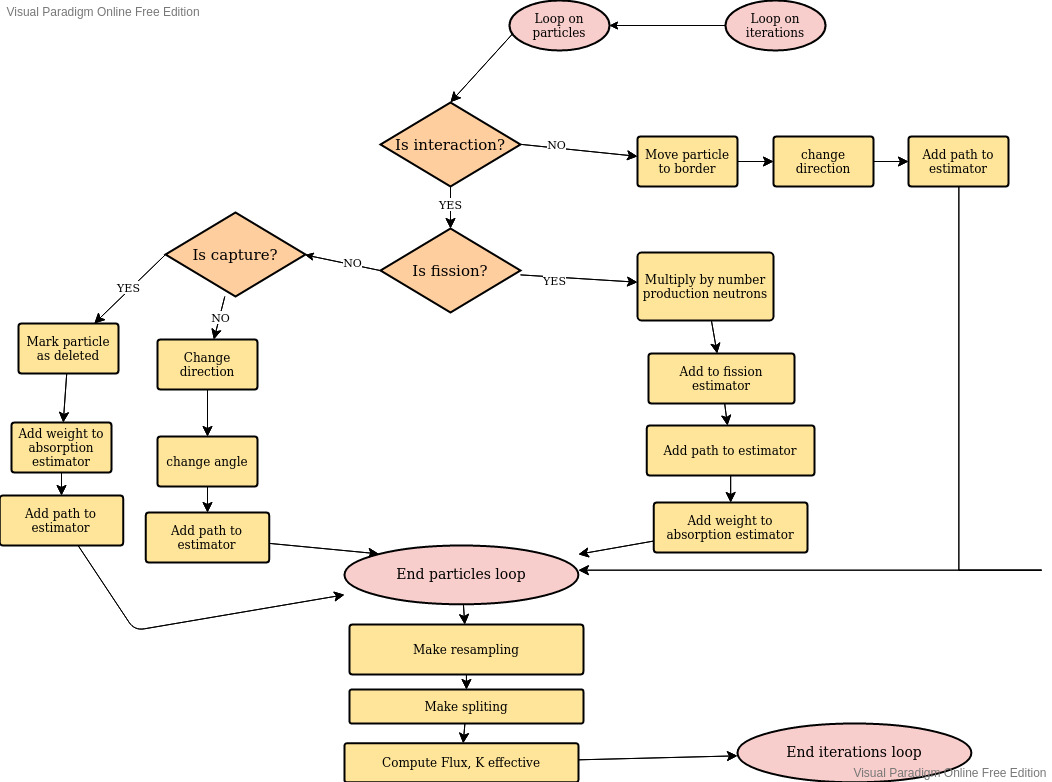

In [6]:
def process_collision_weights(cross_section, weight): 
    
    energy_group_idx = 0 # we assume that only 1 group
    total_cs_particle = cross_section.total[energy_group_idx]    
    capture_cs_particle = cross_section.capture[energy_group_idx]    
    scatter_cs_particle = cross_section.scattering[energy_group_idx]   
    fission_cs_particle = cross_section.fission[energy_group_idx]     
    number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
    capture_probability = capture_cs_particle / total_cs_particle
    scatter_probability = scatter_cs_particle / total_cs_particle   
    fission_probability = fission_cs_particle / total_cs_particle
   

    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                       fission_probability])
    absorbtion_weight = 0.
    weight_capture_fission = 0.

    if type_collision == 'capture':
        weight *= 0
        weight_capture_fission = weight
       
        absorbtion_weight = weight
                
    if type_collision == 'scatter':
        weight = weight
        absorbtion_weight = weight
        
    if type_collision == 'fission':
        
        random_value = random.uniform(0, 1)
       # if weights_current_iteration[i] - n_value > random_value:
            
        weight_capture_fission = weight      
        weight_fission = weight      
        weight *= number_of_production_neutrons
        absorbtion_weight = weight
        
        
    return weight, weight_capture_fission, absorbtion_weight

Non-analog Monte Carlo: Russian roulette


simple implementatios:
* for each neutron set the terminate probability as P = (1 – W / W<sub>0</sub> ),
where W <sub>0</sub> is the weight at the beginning of the generation;
* generate random ξ;
* if P > ξ terminate the neutron;
* otherwise and if P > 0 keep the neutron and set W = W <sub>0</sub>



In [7]:
def resampling(weights_previous_iteration, weights_current_iteration):
    
    weights_resampling = []
    for i in range(0, len(weights_previous_iteration)):
        random_value = random.uniform(0, 1)
        probabilities_terminate = 1 - (weights_current_iteration[i]/weights_previous_iteration[i])

        if probabilities_terminate > 0:
            if random_value < probabilities_terminate:
                weights_resampling.append(0)
            else:
                weights_resampling.append(weights_previous_iteration[i])
        else:
            weights_resampling.append(weights_current_iteration[i])           
            
    return weights_resampling

splitting

One of the simplest algorithms is for every neutron with W > 1:
* Generate random ξ
* calculate N = floor(W) = W
* if W – N > ξ , split the neutron in N + 1 identical neutrons with W / (N+1);
* otherwise, split the neutron in N identical neutrons with W / N

In [8]:
def partifcles_splitting(weights_current_iteration):
    
    weights_splitting = []
    for i in range(0, len(weights_current_iteration)):
        if weights_current_iteration[i] > 1:
            n_value = math.floor(weights_current_iteration[i])
            random_value = random.uniform(0, 1)
            if weights_current_iteration[i] - n_value > random_value:
                for j in range(0, n_value + 1):
                    weights_splitting.append(weights_current_iteration[i]/(n_value + 1))
            else:
                for j in range(0, n_value):
                    weights_splitting.append(weights_current_iteration[i]/(n_value))
        else:
            weights_splitting.append(weights_current_iteration[i])
            
                    
    return weights_splitting    

we make equal number of weights in the beginning of each interation

we assume that at the end of each cycle, each particle has the same weight 

In [9]:
def redristribute_weights(k_effective, weights_after_iteration):
    
    redristribute_weights = []
    for i in range(0, len(weights_after_iteration)):
        redristribute_weights.append(weights_after_iteration[i]/k_effective)
    return redristribute_weights

In [10]:
def k_effective_weight_absorbiton_estimator(weights_previous_iteration, weights_current_iteraion,
                                           cross_section):
    
    energy_group_idx = 0
    total_cs_particle = cross_section.total[energy_group_idx]      
    fission_cs_particle = cross_section.fission[energy_group_idx]     

    fission_probability = fission_cs_particle / total_cs_particle
    
    sum_weights_previous_iteration = sum(weights_previous_iteration)

    number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
    k_effective_collision = (fission_probability * number_of_production_neutrons
                             * weights_current_iteraion) / sum_weights_previous_iteration

    
    return k_effective_collision
    
    

In [11]:
import statistics
import time
import numpy as np

def simulation_simple(number_of_particles, cross_sections, number_interations, number_inactive):
    
    np.random.seed(int(time.time()))
    
  # number_interations = 100
    k_effective_sample = []
    
    number_of_production_neutrons = cross_sections.number_of_production_neutrons[0] ## assume 1 group
    initial_weights = [1. for i in range(number_of_particles)] 
    
    for i in range(0, number_interations):
        num_particles_before = sum(initial_weights)
    
        sum_weight = 0
 
        iteration_weights = []
        sum_weight_capture_fission = 0.
        sum_weight_fission = 0.
        sum_test_weights = 0.
        
        for j in range(0, len(initial_weights)): 
           
            current_particle = initial_weights[j]
            weight, weight_capture_fission, weight_fission = process_collision_weights(cross_sections, current_particle)
            sum_weight += weight
            sum_weight_capture_fission += weight_capture_fission
            sum_weight_fission += weight_fission
            iteration_weights.append(weight)       
            
        current_k_effective = sum(iteration_weights) / sum(initial_weights)
        if i > 10:
            k_effective_sample.append(current_k_effective)
            
        if i > 15:
            k_effective_std = statistics.stdev(k_effective_sample)
          #  print("k effective == " + str( current_k_effective) + " +- " + str(k_effective_std))
            
        
        
        iteration_weights = resampling(initial_weights, iteration_weights)
        
      #  print("partifcles_resampling")
       # print(iteration_weights)
        iteration_weights = [value for value in iteration_weights if abs(value)  >  0.00001]
        
        iteration_weights = partifcles_splitting(iteration_weights)
        
       # print("partifcles_splitting")
       # print(iteration_weights)
        
        iteration_weights = redristribute_weights(current_k_effective, iteration_weights)
        
        
        
        k_effective_absorbiton = k_effective_weight_absorbiton_estimator(initial_weights, sum_weight_fission,
                                           cross_sections)
        print(" k_effective  "+ str(k_effective_absorbiton))
        
        

        initial_weights = iteration_weights

            
    return k_effective_sample, k_effective_std
            


In [12]:
batch_size = 1000
k_effective_sample, k_effective_std = simulation_simple(batch_size, pu_23_cs)
print("k_effective_std  " + str(k_effective_std))

 k_effective  1.249473600000002
 k_effective  1.216483725754596
 k_effective  1.2141087553076464
 k_effective  1.2199932832812954
 k_effective  1.1718432121755193
 k_effective  1.1961803855857238
 k_effective  1.2146706814240142
 k_effective  1.2175067801605524
 k_effective  1.197250958419025
 k_effective  1.2303036044553328
 k_effective  1.1903938463349057
 k_effective  1.2169058912007948
 k_effective  1.2240873920260913
 k_effective  1.216830003342344
 k_effective  1.2158324275425572
 k_effective  1.1968603135876947
 k_effective  1.2134899939678057
 k_effective  1.2278848654726706
 k_effective  1.19408243390964
 k_effective  1.2063285098005652
 k_effective  1.233373695569457
 k_effective  1.2009199584219221
 k_effective  1.2177694761457742
 k_effective  1.2326815088187446
 k_effective  1.201685189141868
 k_effective  1.205444249105679
 k_effective  1.2112019193742423
 k_effective  1.2161969918693214
 k_effective  1.219127348910839
 k_effective  1.2258175926808605
 k_effective  1.2373

KeyboardInterrupt: 

In [ ]:
batch_size = 1600
k_effective_sample, k_effective_std = simulation_simple(batch_size, pu_23_cs)
print("k_effective_std  " + str(k_effective_std))

In [75]:
batch_size = 6400
k_effective_sample, k_effective_std = simulation_simple(batch_size, pu_23_cs)
print("k_effective_std  " + str(k_effective_std))

k_effective_std  0.02960221130350089


In [76]:
batch_size = 25600
k_effective_sample, k_effective_std = simulation_simple(batch_size, pu_23_cs)
print("k_effective_std  " + str(k_effective_std))

k_effective_std  0.014613825337526228


In [77]:
batch_size = 102400
k_effective_sample, k_effective_std = simulation_simple(batch_size, pu_23_cs)
print("k_effective_std  " + str(k_effective_std))

k_effective_std  0.007992465204127275


In [80]:
num_particles = [100, 400, 1600, 6400, 25600, 102400]

k_effective_std = [0.0311105, 0.01504127, 0.007062, 0.0040714, 0.001994, 0.00090]

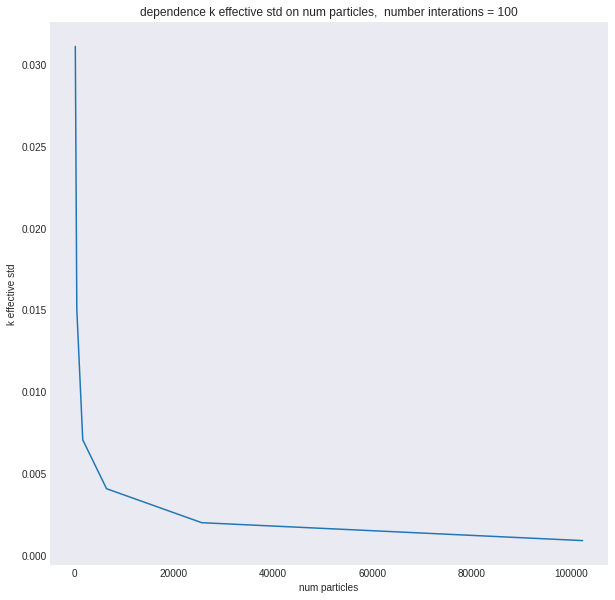

In [81]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (10,10))
#axs.set_xscale('log')
plt.plot(num_particles, k_effective_std)
plt.title('dependence k effective std on num particles,  number interations = 100')
plt.ylabel('k effective std')
plt.xlabel('num particles')
plt.show()

In [3]:
energy_groups_2 = [0, 2 * 1E10]

### Table 2
Critical Dimensions r<sub>c</sub>, for one groups bare Pu_239


| N           |  Geometry| r<sub>c</sub>| 
|----------|--------------|------------------|
| 6 |Slab    |0.73660355   |
| 7 |  Cylinder | 1.396979 |


In [13]:
class Positon:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z


In [14]:
class Direction:
    def __init__(self, ets, phi):
        self.tetta_x = math.sin(ets) * math.cos(phi)
        self.tetta_y = math.sin(ets) * math.sin(phi)
        self.tetta_z = math.cos(ets)
        

In [15]:
class Particle:
    def __init__(self):
        self.coordinates = Positon(0, 0, 0)
        self.direction = Direction(0, 0)
        self.energy = 0
        self.weight = 1
        self.energy_groups = []
        self.terminated = False
        self.path = 0. 
        
    def set_coordinates(self, x, y, z):
        self.coordinates = Positon(x, y, z)
        
    def set_direction(self, ets, phi):
        self.direction = Direction(ets, phi)
    
    def set_direction_angle(self, angle):
        self.direction = angle
        
    def set_energy_groups(self, energy_groups):
        self.energy_groups = energy_groups
        
    def get_energy_group(self):  
        res = next(x for x, val in enumerate(self.energy_groups)
                                  if val > self.energy)        
        return res - 1
    
    def set_terminated(self):
        self.terminated = True
        
    def is_terminated(self):
        return self.terminated
        
    def get_weight(self):
        return self.weight
    
    def set_weight(self, weight):
        self.weight = weight
    
    def set_particle_deleted(self):
        self.weight = self.weight * 0
        
    def set_particle_fission(self, additional_weight):
        self.weight = self.weight * additional_weight
        
    def set_multiplicity(self, additional_weight):
        self.weight = self.weight * additional_weight
              
    def is_particle_deleted(self):
        return self.weight < 0.0001
    
    def add_path(self, path):
        self.path += path
    
    def get_path(self):
        return self.path
        

In [16]:
import random

def make_initial_sources(number_of_paricles, energy=10.0e6, box_size=[5., 5., 5.]):
    
    step_x = 2 * box_size[0]/number_of_paricles
    step_y = 2 * box_size[1]/number_of_paricles
    step_z = 2 * box_size[2]/number_of_paricles
    
    x_coord = -box_size[0]
    y_coord = -box_size[1]
    z_coord = -box_size[2]
    
    sources = []
    for i in range(0, number_of_paricles):
        for j in range(0, number_of_paricles):
            for k in range(0, number_of_paricles):
                eps = random.uniform(0, math.pi * 2.)
                tetta = random.uniform(0, math.pi * 2.)
                current_particle = Particle()
                current_particle.set_coordinates(x_coord + k * step_x, y_coord + j * step_y, z_coord+ i * step_z)
                current_particle.set_direction(eps, tetta)
                current_particle.energy = energy
                current_particle.set_energy_groups(energy_groups_2)
                sources.append(current_particle)

    return sources


In [18]:
## Infinite cylinder parallel to z-axis

class ZCylinder:
    def __init__(self, x_0, y_0, r):
        self.x_0 = x_0
        self.y_0 = y_0
        self.r = r
        
    def distance_to_point(self, particle):
    
        a_ = particle.direction.tetta_x * particle.direction.tetta_x + (particle.direction.tetta_y * particle.direction.tetta_y )
        
        ## If a=0a 0a=0, this means the particle is parallel to the cylinder and will thus never intersect it
        if (abs(a_) < 1e-9):
            return -1
        
        c_ = ((particle.coordinates.x - self.x_0) * (particle.coordinates.x - self.x_0) + 
              (particle.coordinates.y - self.y_0) * (particle.coordinates.y - self.y_0) - self.r * self.r)

        k_ = (particle.coordinates.x -self.x_0) * particle.direction.tetta_x + (particle.coordinates.y -self.y_0) * particle.direction.tetta_y
        
        dec = k_ * k_ - a_ * c_
        
        if dec < 0:
            return -1
        
        dist_1 = (-k_ + math.sqrt(k_ * k_ - a_ * c_))/a_
        dist_2 = (-k_ - math.sqrt(k_ * k_ - a_ * c_))/a_
         
        distance = min(dist_1, dist_2)
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        
        eps = random.uniform(0, math.pi * 2)
        tetta = random.uniform(0, math.pi * 2)
        r_reflected = Direction(eps, tetta)
        
        return r_reflected  
    
    def get_sign(self, particle):
            
        sign = ((self.x_0 - particle.coordinates.x) * (self.x_0 - particle.coordinates.x) + 
        (self.y_0 - particle.coordinates.y) * (self.y_0 - particle.coordinates.y) - self.r * self.r)
        
        if sign == 0:
            return 0
            
        if sign < 0:
            return -1
        else:
            return 1  
    

In [19]:
class Plane:
    def __init__(self, A, B, C, D):
        self.A = A
        self.B = B
        self.C = C
        self.D = D
        
    def distance_to_point(self, particle):
        vp = (self.A * particle.direction.tetta_x + self.B * particle.direction.tetta_y + 
              self.C * particle.direction.tetta_z)
        
        
        if (abs(vp) < 1e-9):
            return -1
        
        distance = (self.D - self.A * particle.coordinates.x - self.B * particle.coordinates.y 
                    - self.C * particle.coordinates.z) / vp
        
        return distance 
    
    def get_normal(self):
        sq = math.sqrt(self.A * self.A + self.B * self.B + self.C * self.C)
        a_n = self.A / sq
        b_n = self.B / sq
        c_n = self.C / sq
        return [a_n, b_n, c_n]
    
    def get_reflected_direction(self, angle):
        normal = self.get_normal()
        
        scalar_mult = angle.tetta_x * normal[0] + angle.tetta_y * normal[1] + angle.tetta_z * normal[2]
        scalar_mult *= 2.
        normal = [scalar_mult * normal[0],  scalar_mult * normal[1], scalar_mult * normal[2]]
        r_reflected = Direction(0, 0)      
        
        r_reflected.tetta_x = angle.tetta_x - normal[0]
        r_reflected.tetta_y = angle.tetta_y - normal[1]
        r_reflected.tetta_z = angle.tetta_z - normal[2]
        
        return r_reflected
    
    def get_sign(self, particle):
      
        sign = (self.A * particle.coordinates.x + self.B * particle.coordinates.y +
        self.C * particle.coordinates.z - self.D)
        
        if sign == 0:
            return sign    
            
        if sign < 0:
            return -1
        else:
            return 1    
        

In [20]:
class Cell:
    def __init__(self):
        self.surfaces = []
        self.signs = []
        self.size = 0
        
    def __init__(self, surfaces, signs):
        self.surfaces = surfaces
        self.signs = signs
        self.size = len(self.signs)
        
    def is_inside(self, particle):
        
        is_inside = True
        for i in range(0, self.size):
            sign = self.surfaces[i].get_sign(particle)
            if self.signs[i] != sign:
                is_inside = False
                
        return is_inside  
    

In [21]:
plane_1 = Plane(1, 0, 0, 5)
plane_2 = Plane(1, 0, 0, -5)

plane_3 = Plane(0, 1, 0, 5)
plane_4 = Plane(0, 1, 0, -5)

plane_5 = Plane(0, 0, 1, 5)
plane_6 = Plane(0, 0, 1, -5)

surfaces = [plane_1, plane_2, plane_3, plane_4, plane_5, plane_6]
signs = [-1, +1, -1, +1, -1, +1]
box = Cell(surfaces, signs)

In [22]:
particle_inside = Particle()

particle_inside.set_coordinates(1, 1, 1)
particle_inside.set_direction(0.5, 0.6)
box.is_inside(particle_inside)



True

In [87]:
particle_outside = Particle()

particle_outside.set_coordinates(10, 10, 10)
particle_outside.set_direction(0.5, 0.6)
box.is_inside(particle_outside)


False

In [88]:
test_cylinder = ZCylinder(1, 5, 5)

plane_5 = Plane(0, 0, 1, 5)
plane_6 = Plane(0, 0, 1, -5)

surfaces = [test_cylinder, plane_5, plane_6]
signs = [-1, -1, +1]

cylinder = Cell(surfaces, signs)

In [89]:
particle_inside = Particle()

particle_inside.set_coordinates(1, 1, 1)
particle_inside.set_direction(0.5, 0.6)
cylinder.is_inside(particle_inside)

True

In [90]:
particle_outside = Particle()

particle_outside.set_coordinates(9, 9, 9)
particle_outside.set_direction(0.5, 0.6)
box.is_inside(particle_outside)

False

In [21]:
def get_cylinder_volume(cylinder, border_plane1, border_plane2):
    
    d = math.fabs(border_plane1.D - border_plane2.D)/ (math.sqrt(border_plane1.A * border_plane1.A + border_plane1.B * border_plane1.B  
                                                      + border_plane1.C * border_plane1.C))
    v = math.pi * d * cylinder.r * cylinder.r
    
    return v

In [23]:
def get_minimum_distance(surfaces, particle):

    minimum_distance = +math.inf
    plane_idx = -1
    for i in range(0, len(surfaces)):
        current_distance = surfaces[i].distance_to_point(particle)
        if (current_distance > 0. and minimum_distance > current_distance):
            plane_idx = i
            minimum_distance = current_distance
            
            
    return plane_idx, minimum_distance
        
        

In [24]:
def get_free_path(particle, cross_sections):
    
    energy_group_idx = particle.get_energy_group()   
    total_cs = cross_sections.total[energy_group_idx]
    free_path = -math.log(random.uniform(0, 1)) / total_cs
    
    return free_path  

In [25]:
def is_absorprion(particle):
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    total_CS_particle = total_cs[energy_group_idx]
    absorption_particle = absorption_cs[energy_group_idx]
    fission_particle = fission_cs[energy_group_idx]  
    
    return total_CS_particle * random_number < absorption_particle - fission_particle
      

In [26]:
def set_random_direction_vector(particle):
    eps = random.uniform(0, math.pi * 2)
    tetta = random.uniform(0, math.pi)
    particle.set_direction(eps, tetta)

In [27]:
def move_particle(particle, t):
    new_x = particle.direction.tetta_x * (t - 0.001) + particle.coordinates.x
    new_y = particle.direction.tetta_y * (t - 0.001) + particle.coordinates.y
    new_z = particle.direction.tetta_z * (t - 0.001) + particle.coordinates.z
    particle.set_coordinates(new_x, new_y, new_z)


In [28]:
def move_particle_to_boundary(particle, universe):
    
    plane_idx, minimum_distance = get_minimum_distance(universe, particle)
    particle.set_path(minimum_distance)
    move_to_intersection_point(particle, minimum_distance)  
    new_angle = universe[plane_idx].get_reflected_direction(particle.direction)
    particle.set_direction_angle(new_angle)    

In [29]:
def process_collision(particle, t_collision, cross_section):
     
    energy_group_idx = particle.get_energy_group()
    total_cs_particle = cross_section.total[energy_group_idx]    
    capture_cs_particle = cross_section.capture[energy_group_idx]    
    scatter_cs_particle = cross_section.scattering[energy_group_idx]   
    fission_cs_particle = cross_section.fission[energy_group_idx]     
    number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
    capture_probability = capture_cs_particle / total_cs_particle
    scatter_probability = scatter_cs_particle / total_cs_particle   
    fission_probability = fission_cs_particle / total_cs_particle
    
    particle.set_path(t_collision)
    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                       fission_probability])
    if type_collision == 'capture':
        particle.set_particle_deleted()
        
    if type_collision == 'scatter':
        move_to_intersection_point(particle, t_collision)
        set_random_direction_vector(particle)
        
    if type_collision == 'fission':    
        particle.set_particle_fission(number_of_production_neutrons)


In [30]:
def is_collision_virual(particle, cross_sections):
    
    energy_group_idx = particle.get_energy_group()
    random_number = random.uniform(0, 1)
    virtual_cs = cross_sections.virtual[energy_group_idx]
    total_cs = cross_sections.total[energy_group_idx]
    if virtual_cs / total_cs >= random_number:
        return True
    else:
        return False

In [31]:
def process_virtual_collision(particle, free_path):
    move_particle(particle, free_path)
    

In [32]:
def process_real_collision(particle, free_path, universe, cross_sections):
    
    energy_group_idx = particle.get_energy_group()
    total_cs_particle = cross_sections.total[energy_group_idx]    
    capture_cs_particle = cross_sections.capture[energy_group_idx]    
    scatter_cs_particle = cross_sections.scattering[energy_group_idx]   
    fission_cs_particle = cross_sections.fission[energy_group_idx]     
    number_of_production_neutrons = cross_sections.number_of_production_neutrons[energy_group_idx]   
    capture_probability = capture_cs_particle / total_cs_particle
    scatter_probability = scatter_cs_particle / total_cs_particle   
    fission_probability = fission_cs_particle / total_cs_particle
    move_particle(particle, free_path)
    
    
    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                            fission_probability])
    if type_collision == 'capture':
        particle.set_terminated()
        particle.set_weight(0.)
        
    if type_collision == 'scatter':      
        set_random_direction_vector(particle)
        
    if type_collision == 'fission':    
        particle.set_particle_fission(number_of_production_neutrons)
        particle.set_terminated()

In [33]:
def one_iteration_v2(particle, universe, cross_sections):
    
    while not particle.is_terminated():
        free_path = get_free_path(particle, cross_sections)
        if is_collision_virual(particle, cross_sections):
            process_virtual_collision(particle, free_path)
        else:
            process_real_collision(particle, free_path, universe, cross_sections)
            
    return particle


In [34]:
def delete_absorpbed_paricles(particles):
    
    existing_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        if particle.get_weight() > 0.0001:
            existing_particles.append(particle)
                     
    return existing_particles
            

In [35]:
def sum_weights(particles):
    sum_particles = 0. 
    
    for i in range(0, len(particles)):
        sum_particles += particles[i].get_weight()
        
    return sum_particles


In [36]:
make_test_sample_particles = []
energy_groups_2 = [0, 2 * 1E10]

def produce_particles_equal_weights():
    x_coord = 0
    step_x = 5
    eps = 2.14
    tetta = 3.14
    energy = 1e6
    sources = []
    number_of_paricles = 10
    
    for i in range(0, number_of_paricles):

        current_particle = Particle()
        current_particle.set_coordinates(x_coord + i * step_x, x_coord + i * step_x, x_coord + i * step_x)
        current_particle.set_direction(eps, tetta)
        current_particle.energy = energy
        current_particle.set_energy_groups(energy_groups_2)
        sources.append(current_particle)
        
    return sources
        
def print_weights(sources):
    
    for i in range(0, len(sources)):
        print(str(sources[i].weight) + "   ")

    

In [37]:
def make_resampling(iteration_sources, batch_size):
    
    sum_additional_weight = 0.
    
    for i in range(0, len(iteration_sources)):
        sum_additional_weight += iteration_sources[i].get_weight()
        
    
    additional_weight = sum_additional_weight / len(iteration_sources)
    
    new_initial_sources = []
    for i in range(0, len(iteration_sources)):
        iteration_sources[i].set_weight(additional_weight)


In [38]:
def mark_particles_to_delete(iteration_sources, num_particles_to_delete):
    
    sum_weights = 0.
    for i in range(0, len(iteration_sources)):
        sum_weights +=iteration_sources[i].get_weight()
        
    probabilities = []
    for i in range(0, len(iteration_sources)):
        probabilities.append(1/iteration_sources[i].get_weight())
        
    probabilities = [number / sum(probabilities) for number in probabilities]
 
        
    indexes = list(range(0, len(iteration_sources)))
    indexes_to_delete = np.random.choice(indexes, num_particles_to_delete, replace=False, p=probabilities)
    
    deleted_weight = 0.

    for i in range(0, len(indexes_to_delete)):
        iteration_sources[indexes_to_delete[i]].set_particle_deleted()
        deleted_weight += iteration_sources[indexes_to_delete[i]].get_weight()
        

        
 

In [39]:
def pathlenght_k_eff_estimator(sum_weights_last_iteration, particles_current_iteration, cross_section):
    
    sum_weighted_paths = 0.
    for i in range(0, len(particles_current_iteration)):
        particle = particles_current_iteration[i]
        energy_group_idx = particle.get_energy_group() 
        fission_cs_particle = cross_section.fission[energy_group_idx]     
        number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
        sum_weighted_paths +=  particles_current_iteration[i].get_weight()* (
            particles_current_iteration[i].get_path()* number_of_production_neutrons * fission_cs_particle)
        
    k_eff = sum_weighted_paths / sum_weights_last_iteration
    
    return k_eff
        
    

In [40]:
def flux_estimator(cell_volume, start_weight, particles_current_iteration, cross_section):

    
    sum_weighted_paths = 0.
    for i in range(0, len(particles_current_iteration)):
        particle = particles_current_iteration[i]
        energy_group_idx = particle.get_energy_group() 
        fission_cs_particle = cross_section.fission[energy_group_idx]     
        number_of_production_neutrons = cross_section.number_of_production_neutrons[energy_group_idx]   
        sum_weighted_paths +=  particles_current_iteration[i].get_weight()* (
            particles_current_iteration[i].get_path())
        
    total_flux = sum_weighted_paths/(cell_volume * start_weight)
    
    return total_flux
    

In [41]:
def russian_roulette(weights_previous, particles_current):
    
    for i in range(0, len(particles_current)):
        particle = particles_current[i]
        if particle.weight > 0 and particle.weight < 0.5 and particle.weight <weights_previous[i]:
            probability_terminate = 1. - particle.weight / weights_previous[i]
            random_number = random.uniform(0, 1)
            if probability_terminate > random_number:
                particle.set_weight(0.)
            else:
                particle.set_weight(weights_previous[i])
            

In [42]:
def get_weights(particles):
    
    weights = []
    for i in range(0, len(particles)):
        weights.append(particles[i].weight)
        
    return weights

In [43]:
def make_sources(particles):
    for i in range(0, len(particles)):
        particles[i].terminated = False
    

In [44]:
def calculate_k_effective(weights, batch_size):
    
    k_effective = sum(weights) / batch_size
    
    return k_effective

In [45]:
def splitting(particles):
    
    splitting_particles = []
    for i in range(0, len(particles)):
        particle = particles[i]
        n_value = math.floor(particle.get_weight())
        if particle.get_weight() > 1.0 and n_value > 1:       
            random_value = random.uniform(0, 1)
            splitted_weight = particle.get_weight() / n_value
            if particle.get_weight() - n_value >= random_value:
                n_value +=1
            particle.set_weight(splitted_weight)
            for i in range(0, n_value - 1):
                splitting_particles.append(particle)
        else:
            splitting_particles.append(particle)
    return splitting_particles

In [46]:
def normalise_weights(particles, sum_weights, batch_size):
    for i in range(0, len(particles)):
        new_weight = particles[i].get_weight() / sum_weights *  batch_size
        particles[i].set_weight(new_weight)
     

In [47]:
import statistics

def simulation(universe, cell_volume, number_interations, number_of_particles, number_inactive, cross_sections):
    
    k_effective_sample = []
    
    initial_sources = make_initial_sources(number_of_particles, energy=10.0e6, box_size=[3., 3., 3.])
    initial_size = len(initial_sources)
    
    weights_previous = [1.] * len(initial_sources)
    for i in range(0, number_interations):
        
        print(len(initial_sources))
        make_sources(initial_sources)
        batch_size = len(initial_sources)
        
        batch_particles = []
        for j in range(0, batch_size):
            
            particle = initial_sources[j]
            terminate_particle = one_iteration_v2(particle, universe, cross_sections)
            batch_particles.append(terminate_particle)
   
        
        russian_roulette(weights_previous, batch_particles)
        
        batch_particles = delete_absorpbed_paricles(batch_particles)
        
        batch_particles = splitting(batch_particles)
        
        
        weights_previous = get_weights(batch_particles)

        normalise_weights(batch_particles, sum(weights_previous), initial_size)
        initial_sources = batch_particles
        current_k_effective = calculate_k_effective(weights_previous, initial_size)
        
        print("current_k_effective " + str(current_k_effective))
        
            
    return initial_sources
    
    

In [48]:
x_5 = Plane(0, 1, 0, 3)
x_m5 = Plane(0, 1, 0, -3)

y_5 = Plane(1, 0, 0, 3)
y_m5 = Plane(1, 0, 0, -3)



z_5 = Plane(0, 0, 1, 3)
z_m5 = Plane(0, 0, 1, -3)

square = [x_5, x_m5, y_5, y_m5, z_5, z_m5]

In [49]:
test_number_of_particles = 20
test_number_interations = 5
test_number_inactive = 2


new_particles = simulation(square, 36, test_number_interations, test_number_of_particles, test_number_inactive, pu_23_cs)


    

8000
current_k_effective 1.9448099999998798
14406
current_k_effective 1.123091501833771
9451
current_k_effective 1.352247997472529
9046
current_k_effective 1.231915901810624
7557
current_k_effective 1.160831744918097


In [397]:
plane1 = Plane(5, 5, 0., 1)

plane2 = Plane(5, 5, 0., -1)
test_cylinder = [ZCylinder(0., 0., 5.), plane1, plane2]

In [486]:
volume = get_cylinder_volume(ZCylinder(0., 0., 5.), plane1, plane2)

In [487]:
test_number_of_particles = 30
test_number_interations = 100
test_number_inactive = 2


new_particles = simulation(test_cylinder, volume, test_number_interations, test_number_of_particles, test_number_inactive, pu_23_cs)



27000
 flux == 0.14837959262224412
27000
 flux == 0.16680911536856985
27000
 flux == 0.1640263746760632
27000
 flux == 0.16374318783949904
27000
 flux == 0.16348746766079872
27000
 flux == 0.16417816247367079
k effective == 0.9642406458368469  +- 0.0020509147610448955
27000
 flux == 0.16141597235415964
k effective == 0.9480179281219484  +- 0.007206741707951788
27000
 flux == 0.16022045857273026
k effective == 0.9409965133165663  +- 0.010022607129274313
27000
 flux == 0.16168754731514612
k effective == 0.9496129247513933  +- 0.009232764689199984
27000
 flux == 0.1618342539288975
k effective == 0.9504745526187085  +- 0.008540388262101207
27000
 flux == 0.16257540461804068
k effective == 0.954827431274401  +- 0.007918728038106778
27000
 flux == 0.16225482904722688
k effective == 0.9529446474084852  +- 0.007412215408431775
27000
 flux == 0.1648096216125544
k effective == 0.9679492911202594  +- 0.008321092062029559
27000
 flux == 0.16358613325650995
k effective == 0.960763577838829  +- 0.00

KeyboardInterrupt: 

In [ ]:

def plot_points(points):
    x = []
    y = []
    z = []
    for point in points:
        x.append(point.coordinates.x)
        y.append(point.coordinates.y)
        z.append(point.coordinates.z)
    fig = plt.figure(figsize=(9, 9), dpi=80)

    ax = fig.add_subplot(projection='3d')


    ax.scatter(x, y, z, marker='o')

    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.show()

        
    

In [ ]:
plot_points(new_particles)

In [190]:
initial_sources = make_initial_sources(test_number_interations, energy=10.0e6, box_size=[10., 10., 10.])


num of particles before
27
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
 absorption_prob

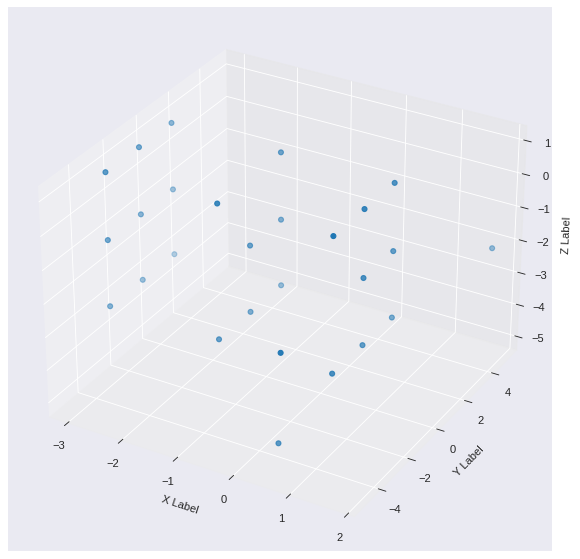

In [31]:

new_particles = simulation(square, 1, 3)
plot_points(new_particles)

In [30]:
f = h5py.File('mgxs.h5','r')
print(f['mixture_material']['294K'].keys())

total_cs = f['mixture_material']['294K']['total'][()]

absorption_cs = f['mixture_material']['294K']['absorption'][()]

chi_cs = f['mixture_material']['294K']['chi'][()]


fission_cs = f['mixture_material']['294K']['fission'][()]



nu_fission_cs = f['mixture_material']['294K']['nu-fission'][()]


scatter_matrix = f['mixture_material']['294K']['scatter_data']['scatter_matrix'][()]


multiplicity_matrix = f['mixture_material']['294K']['scatter_data']['multiplicity_matrix'][()]
multiplicity_matrix = f['mixture_material']['294K']['scatter_data']['multiplicity_matrix'][()]

print( "total_cs")
print( total_cs)

print( "absorption_cs")
print(absorption_cs)

print( "chi_cs")
print(chi_cs)

print( "fission_cs")
print(fission_cs)

print( "nu_fission_cs")
print(nu_fission_cs)


print( "scatter_matrix")
print(scatter_matrix)

print( "multiplicity_matrix")
print(multiplicity_matrix)

<KeysViewHDF5 ['absorption', 'chi', 'fission', 'nu-fission', 'scatter_data', 'total']>
total_cs
[0.39329947]
absorption_cs
[0.02149533]
chi_cs
[1.]
fission_cs
[0.01015952]
nu_fission_cs
[0.02498802]
scatter_matrix
[0.37184555]
multiplicity_matrix
[1.00008631]


In [88]:
0.02149533* 0.472638475 * (0.02498802/0.01015952) * 15625


390.4378121472731

In [89]:
0.02149533*0.52736152457  * 15625


177.12203124898838

In [90]:
390.4 - 177

213.39999999999998

In [93]:
(15625 + 213.39)/ 15625

1.01365696

In [248]:
absorption_probability  0.05465385280921735
 sscatter_probability  0.3718455479816638
capture_probability 0.5273615036749257
fission__probability 0.4726384963250743    
    
    

SyntaxError: invalid syntax (<ipython-input-248-f5207f830b0e>, line 1)

In [13]:
test_particle = Particle()
test_particle.set_coordinates(0., 0., 0)
test_particle.set_direction(3.23, 0.59)
test_particle.energy = 1e6
test_particle.set_energy_groups(energy_groups_2)

plane_idx, minimum_distance = get_minimum_distance(square, test_particle)

print(plane_idx)
print(minimum_distance)

5
5.019603483114459


In [249]:
0.05465385280921735 * 0.4726384963250743 * 2.459566986973731 * 15625

992.7240789139875

In [250]:
 15625 * 0.05465385280921735 * 0.5273615036749257
    

450.34903123588947

In [251]:
992.72 - 450.34

542.3800000000001

In [252]:
(15625 + 542.38)/15625

1.03471232

In [22]:
def get_expected_value(number_of_particles):
    
    #### constants
    ### 
    
    total_CS_particle = 0.39329947    
    absorption_CS_particle = 0.02149533
    scatter_CS_particle = 0.37184555
    fission_CS_particle = 0.01015952
    nu_fission_CS_particle = 0.02498802
    
    
    #### probabilities 
    ###
    
    absorption_probability = absorption_CS_particle / total_CS_particle   
    
    
    fission_probability = fission_CS_particle / absorption_CS_particle
    capture_probability = 1. - fission_probability
    additional_weight = nu_fission_CS_particle / fission_CS_particle
    
    
    expected_value = absorption_probability * fission_probability * additional_weight + (1. - absorption_probability) * 1.00008631
    
    print("expected k effective "+ str(expected_value))
    

In [23]:
#get_expected_value(1000)

number_of_deleted_particles = 0

In [24]:
## simple example


def process_collision_simple(weight): 
    
  #  total_CS_particle = 0.39329947    
   # absorption_CS_particle = 0.02149533
   # scatter_CS_particle = 0.37184555
   # fission_CS_particle = 0.01015952
   # nu_fission_CS_particle = 0.02498802
    
   # absorption_probability = absorption_CS_particle / total_CS_particle   
   # scatter_probability = 1 - absorption_probability
    
    total_CS_particle = 0.39329947    
    absorption_CS_particle = 0.02149533
    scatter_CS_particle = 0.37184555
    fission_CS_particle = 0.01015952
    nu_fission_CS_particle = 0.02498802
    #### probabilities 
    ###
    
    absorption_probability = absorption_CS_particle / total_CS_particle   
    
    
    fission_probability = fission_CS_particle / absorption_CS_particle
    capture_probability = 1. - fission_probability

    additional_weight = nu_fission_CS_particle / fission_CS_particle
    
    scatter_probability = 1. - absorption_probability
    

    
    type_collision = np.random.choice(['absorption', 'scatter'], p=[absorption_probability, scatter_probability])
    
    
    if type_collision == 'absorption':      

        capture_probability = 1. - fission_probability

        type_collision = np.random.choice(['fission', 'capture'], p=[fission_probability, capture_probability])
        
        if type_collision == 'capture':
            weight = 0
            
        if type_collision == 'fission':
            
            weight = weight * additional_weight
    else:
        
        weight = weight
        
                       
    return weight
            
         

In [25]:
#One of the simple implementations:
#− for each neutron set the terminate probability as P = (1 – W / W 0 ),
#where W 0 is the weight at the beginning of the generation;
#− generate random ξ;
#− if P > ξ terminate the neutron;
#− otherwise and if P > 0 keep the neutron and set W = W 0

In [26]:
def resampling(particles_beggining, interation_particles):
    
    particles_resampling = []
    for i in range(0, len(particles_beggining)):
        random_value = random.uniform(0, 1)
        probabilities_terminate = 1 - (interation_particles[i]/particles_beggining[i])

        if probabilities_terminate > 0:
            if random_value < probabilities_terminate:
                particles_resampling.append(0)
            else:
                print("random_value > probabilities_terminate " + str(particles_beggining[i]))
                particles_resampling.append(particles_beggining[i])
        else:
            particles_resampling.append(interation_particles[i])           
            
    return particles_resampling
            
              

In [27]:
# The way around: when the weight of the neutron born in fission or (n,2n)
# reaction is too high, it should be split.
# One of the simplest algorithms is for every neutron with W > 1:
# − Generate random ξ
# − calculate N = floor(W) = W
# − if W – N > ξ , split the neutron in N + 1 identical neutrons with W / (N+1);
# − otherwise, split the neutron in N identical neutrons with W / N

In [28]:
def partifcles_splitting(interation_particles):
    
    particles_splitting = []
    for i in range(0, len(interation_particles)):
        if interation_particles[i] > 1:
            n_value = math.floor(interation_particles[i])
            random_value = random.uniform(0, 1)
        #    n_value_normalized = int(n_value/9000)
            if interation_particles[i] - n_value > random_value:
                for j in range(0, n_value + 1):
                    particles_splitting.append(interation_particles[i]/(n_value + 1))
            else:
                for j in range(0, n_value):
                    particles_splitting.append(interation_particles[i]/(n_value))
        else:
            particles_splitting.append(interation_particles[i])
            
                    
    return particles_splitting      
    

In [29]:

def process_collision_simple_v2(cross_section, weight): 
    
    energy_group_idx = 0
    total_cs_particle = cross_section.total[energy_group_idx]
    
    capture_cs_particle = cross_section.capture[energy_group_idx]  
    
    scatter_cs_particle = cross_section.scattering[energy_group_idx]
    
    fission_cs_particle = cross_section.fission[energy_group_idx] 
    
    number_of_production_neutrons_particle = cross_section.number_of_production_neutrons[energy_group_idx]
    
    capture_probability = capture_cs_particle / total_cs_particle
    

    scatter_probability = scatter_cs_particle / total_cs_particle
    
    fission_probability = fission_cs_particle / total_cs_particle
    
   # print("capture_probability "+ str(capture_probability))
    #print("scatter_probability "+ str(scatter_probability))
    #print("fission_probability "+ str(fission_probability))
    

    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                       fission_probability])
    absorbtion_weight = 0.
    weight_capture_fission = 0.
    weight_fission = 0
    if type_collision == 'capture':
        weight_capture_fission = weight
        
        absorbtion_weight = weight
                
    if type_collision == 'scatter':
        weight = weight
        weight_test = 0
        absorbtion_weight = 0
        
    if type_collision == 'fission':
        weight_capture_fission = weight
        absorbtion_weight = weight
        weight_fission = weight
        
        weight *= 3.24 
        
        
    return weight, weight_capture_fission, weight_fission
        


In [30]:
def redristribute_weights(batch_size, weights_after_iteration):
    
    result_particles = []
    sum_weights = sum(weights_after_iteration)
    redistribution_weights = sum_weights / sum_weights
    for i in range(0, batch_size):
        result_particles.append(redistribution_weights)
    return result_particles
        
    

In [31]:
# k-effective of the cycle is the total weight of neutrons in the system divided by
# the number of neutrons born N born (fixed value = size of the batch).

In [32]:
import statistics
import time
import numpy as np

def simulation_simple(number_of_particles):
    
    np.random.seed(int(time.time()))
    
    number_interations = 100
    k_effective_sample = []
    

    initial_weights = [1. for i in range(number_of_particles)] 
    
    size_initial = 0
    print("number_of_particles "+ str(number_of_particles))
    for i in range(0, number_interations):
        num_particles_before = sum(initial_weights)
    
        sum_weight = 0
 
        iteration_weights = []
        sum_weight_capture_fission = 0.
        sum_weight_fission = 0.
        sum_test_weights = 0.

        size_initial = len(initial_weights)

        for j in range(0, len(initial_weights)): 
           
            current_particle = initial_weights[j]
            weight, weight_capture_fission, weight_fission = process_collision_simple_v2(pu_23_cs, current_particle)
            sum_weight += weight
            sum_weight_capture_fission += weight_capture_fission
            sum_weight_fission += weight_fission
            iteration_weights.append(weight)       
            
        iteration_weights = resampling(initial_weights, iteration_weights)
       
        
        iteration_weights = partifcles_splitting(iteration_weights)

        iteration_weights = [value for value in iteration_weights if abs(value)  >  0.00001]    
        
        if i > 50:
            current_k_effective = sum_weight_fission/ sum_weight_capture_fission
            k_effective_sample.append(current_k_effective)
            
        if i > 55:
            k_effective_std = statistics.stdev(k_effective_sample)
            
        iteration_weights = redristribute_weights(number_of_particles, iteration_weights)
        initial_weights = iteration_weights
        
        
            
            
        
      
            
        #new_initial_sources = [value for value in initial_sources if abs(value)  >  0.00001]
        #additional_weight = sum_additional_weight / len(new_initial_sources)
        
       # print("additional_weight  "+ str(additional_weight))
        #new_initial_sources = [additional_weight for x in new_initial_sources]
                  
        #initial_sources = new_initial_sources

        #num_particles_after = sum(initial_sources)


        
        #current_k_effective = num_particles_after / num_particles_before
        #k_effective_sample.append(current_k_effective)
       # print("k effective == " + str(current_k_effective))
        
      # if (i > 30):
       #    k_effective_std = statistics.stdev(k_effective_sample)

        #   print("k effective == " + str(current_k_effective) +
         #       "  +- " + str(k_effective_std))
            
    return k_effective_sample, k_effective_std
            


In [33]:

batch_size = 10000
k_effective_sample, k_effective_std = simulation_simple(batch_size)
print("k_effective_std  " + str(k_effective_std))

number_of_particles 10000
k_effective_std  0.007595520720621027


In [108]:
batch_size = 40000
k_effective_sample, k_effective_std = simulation_simple(batch_size)
print("k_effective_std  " + str(k_effective_std))

number_of_particles 40000
k_effective_std  0.003340589815942021


In [109]:
batch_size = 160000
k_effective_sample, k_effective_std = simulation_simple(batch_size)
print("k_effective_std  " + str(k_effective_std))

number_of_particles 160000
k_effective_std  0.002009743377570364


In [69]:
1.4956612903225845/1.3962451612903533

1.0712024877782602

In [70]:
2.612903/2.290323

1.1408447629439167

In [573]:
k_effective_sample, k_effective_std = simulation_simple()
print(k_effective_std)

size initial_sources 400
0.015041271883979463


In [575]:
k_effective_sample, k_effective_std = simulation_simple()
print(k_effective_std)

size initial_sources 1600
0.007062934368487556


In [578]:
k_effective_sample, k_effective_std = simulation_simple()
print(k_effective_std)

size initial_sources 6400
0.004071436830397359


In [580]:
k_effective_sample, k_effective_std = simulation_simple()
print(k_effective_std)

size initial_sources 25600
0.0019942528257830294


In [582]:
k_effective_sample, k_effective_std = simulation_simple()
print(k_effective_std)

size initial_sources 102400
0.0009088463342122149


In [78]:
num_particles = [100, 400, 1600, 6400, 25600, 102400]

k_effective_std = [0.0311105, 0.01504127, 0.007062, 0.0040714, 0.001994, 0.00090]

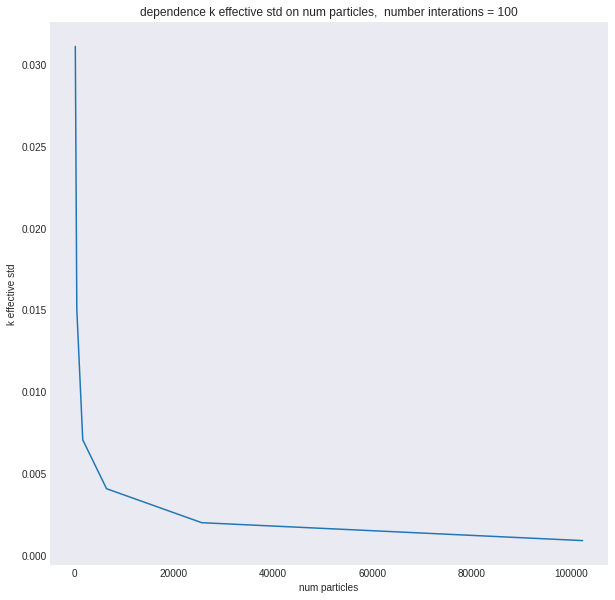

In [79]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (10,10))
#axs.set_xscale('log')
plt.plot(num_particles, k_effective_std)
plt.title('dependence k effective std on num particles,  number interations = 100')
plt.ylabel('k effective std')
plt.xlabel('num particles')
plt.show()

In [564]:
num_iterations = [i for i in range(100)] 

In [565]:
print(nonzero_elements)

[97062, 94283, 91501, 88853, 86310, 83882, 81444, 79058, 76781, 74608, 72524, 70399, 68421, 66333, 64370, 62482, 60647, 58861, 57183, 55497, 53898, 52278, 50777, 49309, 47903, 46554, 45212, 43932, 42710, 41476, 40261, 39038, 37938, 36853, 35812, 34759, 33790, 32815, 31875, 30892, 30008, 29157, 28331, 27530, 26749, 25945, 25208, 24496, 23833, 23137, 22480, 21801, 21184, 20577, 19996, 19411, 18880, 18365, 17833, 17336, 16837, 16336, 15846, 15408, 14960, 14517, 14089, 13717, 13311, 12931, 12550, 12174, 11813, 11492, 11179, 10849, 10507, 10211, 9903, 9623, 9357, 9110, 8840, 8597, 8366, 8103, 7886, 7653, 7440, 7245, 7052, 6840, 6633, 6440, 6230, 6038, 5861, 5700, 5515, 5363]


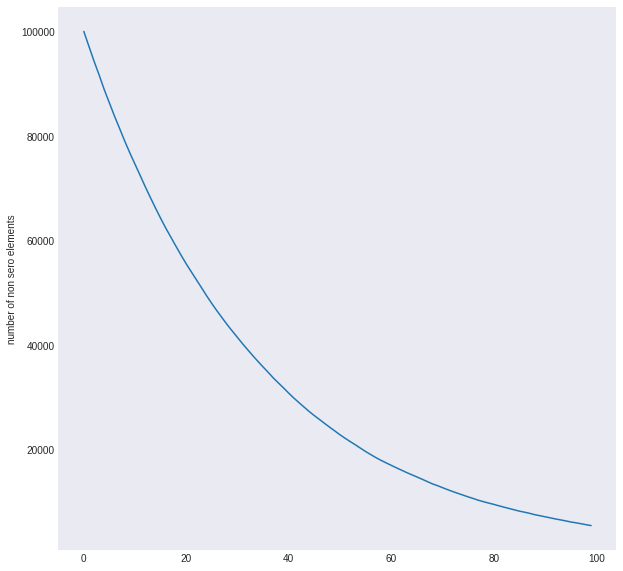

In [566]:
fig, axs = plt.subplots(figsize = (10,10)) 
plt.plot(num_iterations, non_zero)
plt.ylabel('number of non sero elements')
plt.show()

In [567]:
print(num_iterations)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]


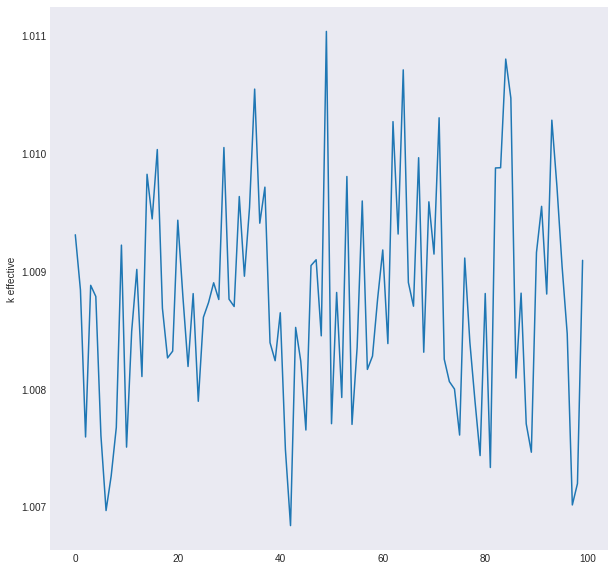

In [568]:

import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize = (10,10)) 
plt.plot(num_iterations, k_effective_sample)
plt.ylabel('k effective')
plt.show()

In [554]:
diff_k_effective = [x - 1.008962077714784 for x in k_effective_sample]

NameError: name 'num_iterations' is not defined

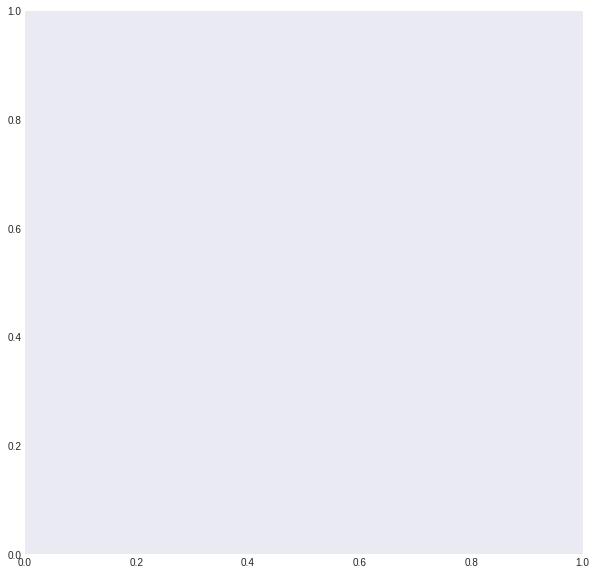

In [29]:
fig, axs = plt.subplots(figsize = (10,10)) 
plt.plot(num_iterations, diff_k_effective)
plt.ylabel('num iteration')
plt.ylabel('diff k effective')
plt.show()

In [28]:

total_CS_particle = 0.39329947    
absorption_CS_particle = 0.02149533
scatter_CS_particle = 0.37184555
fission_CS_particle = 0.01015952
nu_fission_CS_particle = 0.02498802


#### probabilities 
###

absorption_probability = absorption_CS_particle / total_CS_particle   


fission_probability = fission_CS_particle / absorption_CS_particle
capture_probability = 1. - fission_probability

additional_weight = nu_fission_CS_particle / fission_CS_particle

scatter_probability = 1. - absorption_probability

print(" scatter_probability  " + str(scatter_probability))
print(" absorption_probability  " + str(absorption_probability))

number_absorption = 0.
number_scatter = 0.
for i in range(0, 10000):

    type_collision = np.random.choice(['absorption', 'scatter'], p=[absorption_probability, scatter_probability])
    
    if type_collision == 'absorption':
        number_absorption = number_absorption + 1
    else:
        number_scatter = number_scatter +1
        
print("probability  absorption == " + str(number_absorption/10000.))
print("probability  scatter == " + str(number_scatter/10000.))
        
        
    

 scatter_probability  0.9453461506063051
 absorption_probability  0.05465384939369484
probability  absorption == 0.0544
probability  scatter == 0.9456


In [491]:
( 0.02149533 * 0.5273615)


0.011335809471795001

In [492]:
0.02149533/0.39329947 

0.05465384939369484

In [496]:
1 -0.01015952/0.02149533

0.5273615245730119

In [497]:
0.05465384939369484 * 0.5273615245730119

0.028822337340042692

In [499]:
100000 *( 1 - 0.05465384939369484 * 0.5273615245730119)**100

5368.6920815081185

In [50]:
3.24 *0.081600/0.32640 - 0.019584/ 0.32640


0.7500000000000002

In [58]:
import numpy as np
arr = np.array([6, 4, 2, 8, 1, 7, 0, 5, 3, 9], dtype=int)
arr.argsort()[:3]

In [60]:
result = np.argpartition(arr,-4)

In [61]:
print(result)

[6 4 2 8 1 7 0 5 3 9]


In [64]:
arr.argsort()[:3]

array([6, 4, 2])

In [82]:
class Material_CS:
    def __init__(self):
        self.number_groups = 0
        self.fission = []
        self.capture = []
        self.scattering = []
        self.total = []
        self.number_of_production_neutrons = []
        self.c_value = []
        
    def __init__(self, number_groups, fission, capture, scattering, number_of_production_neutrons,
                 c_value, total):
        self.number_groups = number_groups
        self.fission = fission
        self.capture = capture
        self.scattering = scattering      
        self.number_of_production_neutrons = number_of_production_neutrons
        self.c_value = c_value
        self.total = total  
        

In [129]:
from numpy.random import choice

def process_collision(particle, t_collision, cross_section): 
    
    energy_group_idx = particle.get_energy_group()
    total_cs_particle = cross_section.total[energy_group_idx]
    
    capture_cs_particle = cross_section.capture[energy_group_idx]  
    
    scatter_cs_particle = cross_section.scattering[energy_group_idx]
    
    fission_cs_particle = cross_section.fission[energy_group_idx] 
    
    number_of_production_neutrons_particle = cross_section.number_of_production_neutrons[energy_group_idx]
    
    capture_probability = capture_cs_particle / total_cs_particle
    
    c_value_particle = cross_section.c_value[energy_group_idx]  

    scatter_probability = scatter_cs_particle / total_cs_particle
    
    fission_probability = fission_cs_particle / total_cs_particle
    

    type_collision = np.random.choice(['capture', 'scatter', 'fission'], p=[capture_probability, scatter_probability,
                                                                           fission_probability])
    
    if type_collision == 'capture':
       # particle.set_particle_deleted()
        return -1

    if type_collision == 'fission':
        particle.set_particle_fission(number_of_production_neutrons_particle)
        return 0
                
    if type_collision == 'scatter':
        move_to_intersection_point(particle, t_collision)
        set_random_direction_vector(particle)
        return 0


In [67]:
 def move_particle_from_boundary(particle, universe):  
    
    t_collision = -math.log(random.uniform(0, 1))/ total_CS_particle
    move_to_intersection_point(particle, t_collision)


In [ ]:
def move_particle_from_boundary(particle, universe):  
    
    t_collision = -math.log(random.uniform(0, 1))/ total_CS_particle
    move_to_intersection_point(particle, t_collision)
